In [1]:
from algoaux import *
from lib import *
from dataShaper import *
from models import cnn
from graphs import *
import re
import os
sns.set_theme(style="whitegrid")
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

In [2]:
def populateDataLog(input_dir):
    dataLog={}
    for file in os.listdir(input_dir):
        if file != ".DS_Store":
            lossArray = []
            gapArray = []
            localGapArray =[]
            a=open(input_dir+file, "r").read().replace("0>", "").split("\n")
            for item in a:
                try:
                    b=item.strip().replace(":", "").split()
                    loss, gap, local_gap = b[2],b[4], b[-1]
                    lossArray.append(loss)
                    gapArray.append(gap)
                    localGapArray.append(local_gap)
                except:
                    pass
            dataLog[file]={
                "lossArray" :lossArray,
                "gapArray" : gapArray,
                "localGapArray" : localGapArray
            }
    return dataLog

def read_result_from_txt(path):
    files = os.listdir(path)
    #data_file = [file
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            with open(path+file,'r') as f:
                lines = f.readlines()
            result = [line for line in lines if line.startswith("t_")]
            losses = np.zeros(len(result))
            gap = np.zeros(len(result))
            for k,v in enumerate(result):
                modified = re.split('[\n : ]',v)
                #print(modified[4])
                losses[k] = float(modified[6])
                gap[k] = float(modified[10])
            dataLog[int(file.split("-")[1])] = {"losses":losses,
                      "gap":gap}
    return dataLog

def read_result_from_csv(path):
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            try:
                pd_file = pd.read_csv(path+file, index_col=0)
                dataLog[str(file.split("_")[1])] = pd_file
                #dataLog[]
            except:
                print("Skipping unrelated file ...")
                pass
    return dataLog

In [3]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

In [4]:
analysis = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/"
save_path_fig = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/plots/dmfw/"

In [5]:
def plotDeFW(floor, graph_type, feature, path_analysis, save_path, save=False ,metric="loss", average=False):
    
    path_dmfw = os.path.join(path_analysis,f'{graph_type}-{feature}/')
    path_defw = os.path.join(path_analysis,"Defw/"+f'{feature}/'+f'{graph_type}/')
    
    dmfw = read_result_from_txt(path_dmfw)
    defw = read_result_from_csv(path_defw)
    keys_defw = str(floor)
    keys_dmfw = int(floor)
    
    fig = plt.figure(figsize=(10,5))
    #plt.title(f"Floor{floor} - {graph_type} Graph", fontsize=14,**hfont)
    if metric=="loss":
        plt.plot(dmfw[keys_dmfw]["losses"][1:-1], label="DMFW",marker='o', markersize=3,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        if average:
            plt.plot(average_loss(dmfw[keys_dmfw]["losses"][1:-1]), label="DMFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            
        plt.plot(defw[keys_defw]["Loss"][1:-1].values, label="DeFW",marker='^', markersize=3,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        if average:
            plt.plot(average_loss(defw[keys_defw]["Loss"][1:-1]), label="DeFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Loss",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            plt.savefig(save_path+f"Floor{floor}-{graph_type}-{feature}.png")
        plt.show()
        
    elif metric=="gap":
        plt.plot(dmfw[keys_dmfw]["gap"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.plot(defw[keys_defw]["Gap"][1:-1].values, label="DeFW",marker='^', markersize=5,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Gap",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path+f"Floor{floor}-{graph_type}-{feature}.png")
        plt.show()
    else:
        raise ValueError("Unrecognized metric")

In [6]:
def plotOFW(floor, graph_type, feature, path_dmfw, path_analysis, save_path, save=False ,metric="loss", average=False, indep_loss = False):
    #path_dmfw = os.path.join(path_analysis,f'new-{feature}/{graph_type}/alpha/')
    path_ofw = os.path.join(path_analysis,"Ofw/"+f'{feature}/')
    
    print(path_dmfw)
    
    #dmfw = read_result_from_txt(path_dmfw)
    dmfw = read_result_from_csv(path_dmfw)
    ofw = read_result_from_csv(path_ofw)
    
    #print(dmfw)

    
    real_value = [1,2,4,5]
    real_zone = []*len(real_value)
    
    keys_dmfw = str(floor)
    #print(keys_dmfw)
    keys_ofw = sorted([zone for zone in list(ofw.keys()) if zone.split("z")[0] == str(floor)])
    average_ofw = sum([ofw[zone] for zone in keys_ofw])/len(keys_ofw)
    
    print(f'Avg OFW {np.mean(average_ofw)}')
    print(f'Avg DMFW {np.mean(dmfw[keys_dmfw]["Loss"])}')
    
    
    for i in range(len(keys_ofw)):
        real_zone.append(real_value[i])
    
    fig = plt.figure(figsize=(10,5))
    if metric=="loss":
        if average==True:
            plt.plot(average_loss(dmfw[keys_dmfw]["Loss"][1:-1]), label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            if indep_loss:
                for zone, real in zip(keys_ofw,real_zone):
                    plt.plot(average_loss(ofw[zone]["Loss"][1:-1].values), ls='--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1)
            else:
                plt.plot(average_loss(average_ofw["Loss"][1:-1]),ls='--',label="OFW",marker='^', markersize=5,
                     markevery=[i for i in range(504) if i%10==0], linewidth=1)
                
        elif average=="Full":
            plt.plot(dmfw[keys_dmfw]["Loss"][1:-1], label="DMFW ",marker='o', markersize=3,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1,c="#8E94D6")
            plt.plot(average_loss(dmfw[keys_dmfw]["Loss"][1:-1]), label="DMFW Online Loss",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1.3, c="#8E94D6")
            plt.plot(average_ofw["Loss"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1, c="#DFA063")
            plt.plot(average_loss(average_ofw["Loss"][1:-1]),ls='--',label="OFW Online Loss",marker='^', markersize=5,
                     markevery=[i for i in range(504) if i%10==0], linewidth=1.3, c="#DFA063")
        else:
            plt.plot(dmfw[keys_dmfw]["Loss"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            if indep_loss:
                for zone, real in zip(keys_ofw,real_zone):
                    plt.plot(ofw[zone]["Loss"][1:-1].values,ls = '--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=0.3)      
            else :
                plt.plot(average_ofw["Loss"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1)    
            
                
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["Loss"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Loss",**hfont)
        
    if metric=="gap":
        plt.plot(dmfw[keys_dmfw]["Gap"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        if indep_loss:
            for zone, real in zip(keys_ofw,real_zone):
                plt.plot(ofw[zone]["Gap"][1:-1].values,ls = '--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                         markevery=[i for i in range(504) if i%10==0],linewidth=0.3)      
        else :
            plt.plot(average_ofw["Gap"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)    
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Gap",**hfont)  
        
    plt.xlabel("Iteration",**hfont)
    plt.yscale("log")
    if save:
        save_path_feat = save_path+f'{feature}/'
        if not os.path.exists(save_path_feat):
            os.makedirs(save_path_feat)
        plt.savefig(save_path_feat+f"Floor{floor}-{metric}-{graph_type}-{average}-{indep_loss}.png")
    plt.show()

/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp/cycle/alpha099/
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Avg OFW Iteration    251.001980
Loss           0.039948
Gap            0.630498
dtype: float64
Avg DMFW 0.02448694748509472


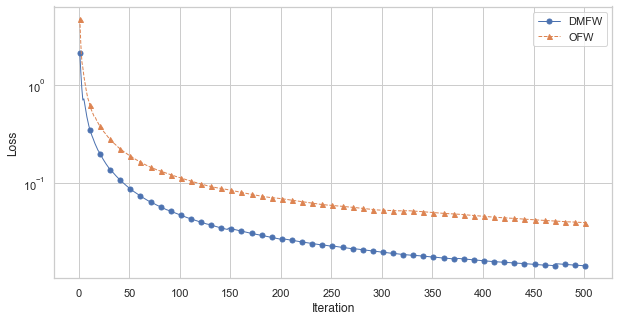

In [206]:
path_dmfw = os.path.join(analysis,"new-temp/cycle/alpha099/")
plotOFW(7, 'cycle','temp', path_dmfw, analysis, save_path_fig, save=True, metric='loss',average=True, indep_loss=False)

In [208]:
#plotDeFW(4, "cycle","temp",analysis,save_path_fig,save=False,metric="loss", average=True)

# Mapping 

In [9]:
graph_type = "line/"
path_ac_power = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp/complete/alpha085-250-relu/"

In [10]:
def plotDMFW(path,path_to_save,metric,floor_idx, save=False):
    data = read_result_from_csv(path)
    #print(np.mean(data[str(floor_idx)][metric][:-1]))
    #print(data.keys())
    plt.figure(figsize=(10,5))
    plt.plot(data[str(floor_idx)][metric][1:-1],label="DMFW"+f' {metric}',marker='o', markersize=5,
                     markevery=[i for i in range(504) if i%10==0], linewidth=1)
    if metric == "Loss":
        plt.plot(average_loss(data[str(floor_idx)][metric][:-1]),ls='--',label="DMFW Online"+f' {metric}',marker='^', markersize=5,
                         markevery=[i for i in range(504) if i%10==0], linewidth=1)
    plt.xticks(ticks=np.arange(len(data[str(floor_idx)][metric][:-1]),step=50))
    plt.legend()
    plt.ylabel(metric,**hfont)
    plt.xlabel("Iteration",**hfont)
    plt.yscale("log")
    if save:
        plt.savefig(path_to_save+f'{metric}-F{floor_idx}')
    plt.show()

In [11]:
def plotPrediction(path, path_to_save,feature,zone_idx, floor_idx,begin,end, save=False):
    files = os.listdir(path)
    prediction_files = [file for file in files if (file.startswith("prediction")) and (file.split(".")[0][-1]==zone_idx)]
    resultpd = pd.read_csv(path+prediction_files[0],index_col=0)
    result_to_plot = resultpd.iloc[begin:end]
    plt.figure(figsize=(15,5))
    plt.title(f'Floor {floor_idx} - Zone {zone_idx}')
    plt.plot(result_to_plot["Truth"],label="Truth")
    plt.plot(result_to_plot["Prediction"],label="Prediction",ls='-')
    #plt.xticks(ticks=np.arange(result_to_plot.shape[0],step=100))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel(f'{feature}')
    if save:
        plt.savefig(path_to_save+f'prediction-F{floor_idx}-zone{zone_idx}')
    plt.show()

In [12]:
prediction_save = "/plots/dmfw/temp/"
path_to_save = analysis + prediction_save
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

In [13]:
classi_line = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp-ac-classification/line/alpha075-200/"
classi_cycle = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp-ac-classification/cycle/alpha075-200/"
classi_complete = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp-ac-classification/complete/alpha075-200/"

In [14]:
plotDMFW(completealpha,analysis+prediction_save,"Loss",7, save=False)

NameError: name 'completealpha' is not defined

Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...


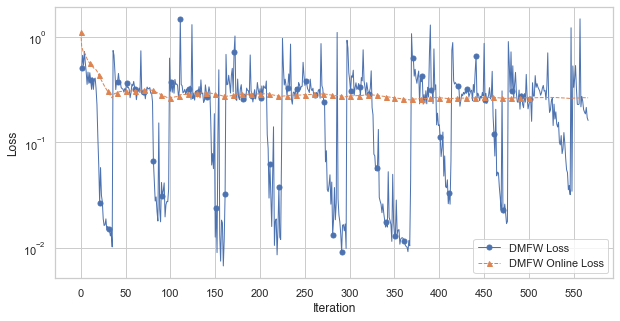

In [311]:
plotDMFW(classi_cycle,analysis+prediction_save,"Loss",7, save=False)

Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...


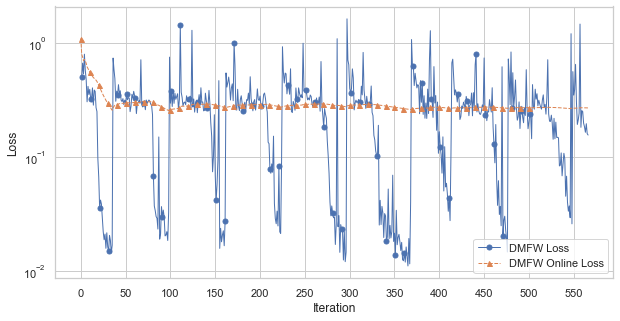

In [124]:
plotDMFW(classi_line,analysis+prediction_save,"Loss",7, save=False)

In [130]:
completealpha ="/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp/complete/"
cyclealpha = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp/cycle/"
linealpha = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp/line/"

In [131]:
def compare_alpha(path_graph):
    folders = os.listdir(path_graph)
    alphas = [ele for ele in folders if len(ele)==8]
    alphas_dict = {}
    for alpha in alphas:
        direct = os.path.join(path_graph,alpha+"/")
        alphas_dict[alpha] = read_result_from_csv(direct)
    return alphas_dict

In [132]:
alphas_complete = compare_alpha(completealpha)
alphas_cycle = compare_alpha(cyclealpha)
alphas_line = compare_alpha(linealpha)

Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated f

alpha090 : 0.02712744350725501
alpha099 : 0.024488197082266353
alpha085 : 0.027716242451874856
-----------------


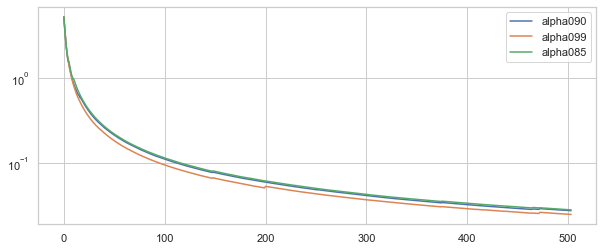

In [184]:
plot_loss_alphas(alphas_line)

In [165]:
def plot_loss_alphas(alphas_dict, alphas_value=None):
    plt.figure(figsize=(10,4))
    for keys in alphas_dict.keys():
        print(f'{keys} : {np.mean(alphas_dict[keys]["7"]["Loss"][:-1])}')
        plt.plot(average_loss(alphas_dict[keys]["7"]["Loss"][:-1]),label=keys)
        plt.legend()
        plt.yscale("log")
    print("-----------------")
    
def compare_alphas_graph(complete_dict, cycle_dict, line_dict, alpha_value):
    alpha_str = f'alpha0{alpha_value}'
    plt.figure(figsize=(10,4))
    print(f'Complete : {np.mean(complete_dict[alpha_str]["7"]["Loss"][:-1])}')
    print(f'Cycle : {np.mean(cycle_dict[alpha_str]["7"]["Loss"][:-1])}')
    print(f'Line : {np.mean(line_dict[alpha_str]["7"]["Loss"][:-1])}')
    plt.plot(average_loss(complete_dict[alpha_str]["7"]["Loss"][:-1]), label="Complete "+alpha_str)
    plt.plot(average_loss(cycle_dict[alpha_str]["7"]["Loss"][:-1]), label="Cycle "+alpha_str)
    plt.plot(average_loss(line_dict[alpha_str]["7"]["Loss"][:-1]), label="Line "+alpha_str)
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Average Loss")
    plt.yscale("log")

In [248]:
alpha_value = 90
zone = 2
nb_timestep = 10000

Complete : 0.026529416560844635
Cycle : 0.028616817447145254
Line : 0.02712744350725501


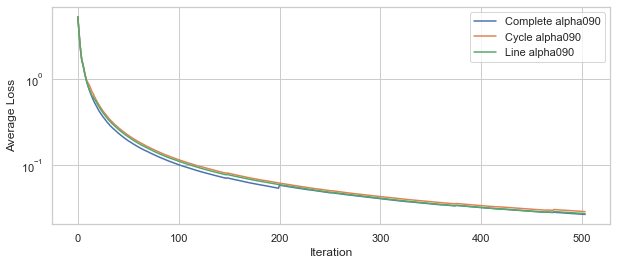

In [249]:
compare_alphas_graph(alphas_complete, alphas_cycle, alphas_line,alpha_value)

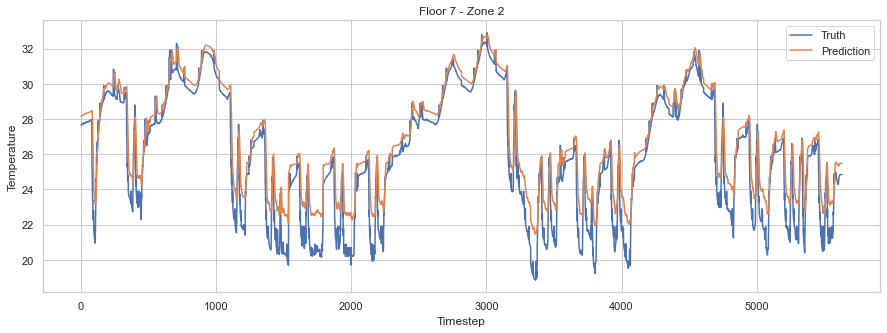

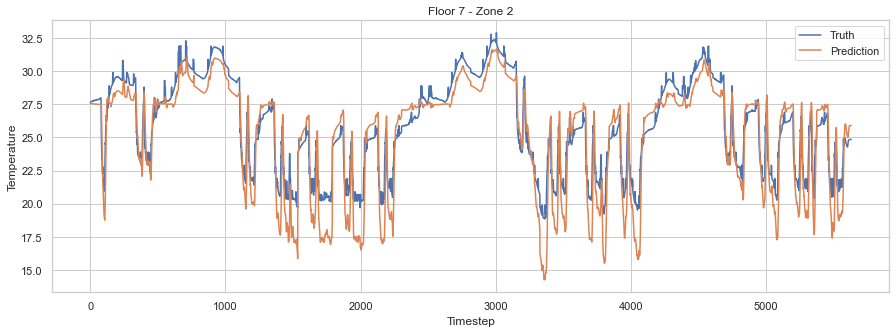

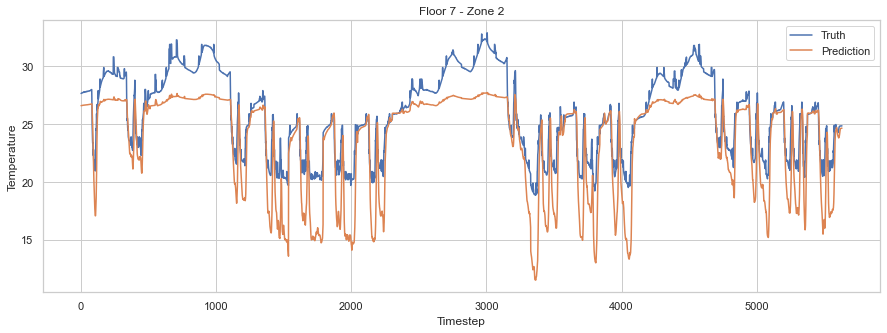

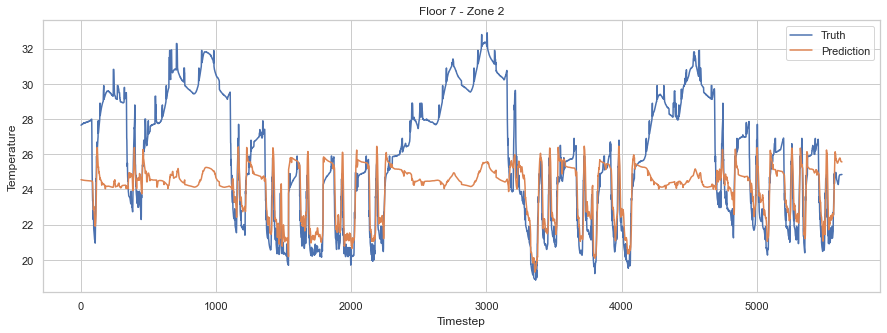

In [253]:
plotPrediction(completealpha+f"/alpha0{alpha_value}-noise001/",analysis+prediction_save,"Temperature", str(zone),"7",0,nb_timestep,save=False)
plotPrediction(completealpha+f"/alpha0{alpha_value}/",analysis+prediction_save,"Temperature", str(zone),"7",0,nb_timestep,save=False)
plotPrediction(cyclealpha+f"/alpha0{alpha_value}/",analysis+prediction_save,"Temperature", str(zone),"7",0,nb_timestep,save=False)
plotPrediction(linealpha+f"/alpha0{alpha_value}/",analysis+prediction_save,"Temperature", str(zone),"7",0,nb_timestep,save=False)

In [235]:
complete, _ = completegraph(4)
cycle, _ = cycle_graph(4)
line, _ = gridgraph(4,1)

In [216]:
nx.adjacency_matrix(cycle).toarray()

array([[0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333]])

In [215]:
nx.adjacency_matrix(complete).toarray()

array([[0.5       , 0.16666667, 0.16666667, 0.16666667],
       [0.16666667, 0.5       , 0.16666667, 0.16666667],
       [0.16666667, 0.16666667, 0.5       , 0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.5       ]])

In [217]:
nx.adjacency_matrix(line).toarray()

array([[0.66666667, 0.33333333, 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.        , 0.33333333, 0.66666667]])

# Classification

In [305]:
graph = "complete"
classi = f"/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp-ac-classification/{graph}/alpha075-200/prediction-zone1.csv"

In [288]:
cycle = pd.read_csv(classi,index_col=0)

<AxesSubplot:>

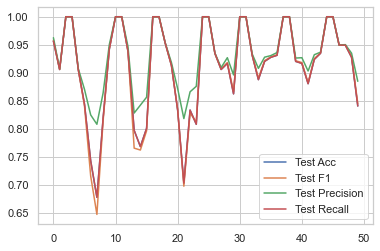

In [285]:
complete = pd.read_csv(classi, index_col=0)
complete.plot()

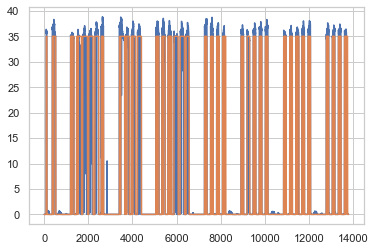

In [292]:
plt.plot(cycle["RealValue"])
plt.plot(cycle["Prediction"]*35)